In [1]:
import numpy as np

import sys
sys.path.append('../')
import mapache

from bs4 import BeautifulSoup, NavigableString
import urllib.request

from tqdm import tqdm

import datetime

from dateutil.parser import parser

import matplotlib.pylab as plt
%matplotlib inline

A party is created from its name(s) and the party logo, that will be used to represent the party

Name: Ciudadanos
Full name: Ciudadanos - Partido de la Ciudadanía
Short name: C's


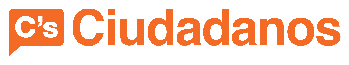

In [2]:
ciudadanos = mapache.Party('Ciudadanos',
                   'https://www.ciudadanos-cs.org/var/public/sections/page-imagen-del-partido/logo-ciudadanos.jpg',
                   short_name = 'C\'s',
                   full_name = 'Ciudadanos - Partido de la Ciudadanía')

ciudadanos.show()

# Parsing the wikipedia polls page

We recover the table with all the polls for the 2016 Spanish National elections

In [3]:
wiki = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2016"
page = urllib.request.urlopen(wiki)
soup = BeautifulSoup(page, "html.parser")
tables = soup.findAll("table", class_="wikitable")


## Creating the parties

The first row of the table is parsed to get the name and parties. Party logos are extracted from their wikipedia pages

In [4]:
def from_wiki_table(table):
    spanish_parties = mapache.PartySet()
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")    
    for c in tqdm(cells[2:-3]):
        
        #From each cell we recover the name, logo and wikipedia url of the party
        url = "http://wikipedia.org" + c.find("a").attrs["href"]
        small_logo = "http:" + c.find("img").attrs["src"]
        name = c.find("a").attrs["title"]
        
        # The party wiki page is fetched to get the full name and full logo
        page = urllib.request.urlopen(url)
        party_soup = BeautifulSoup(page, "html.parser")
        infobox = party_soup.find("table", {"class": "infobox vcard"})
        big_logo = "http:" + infobox.find("td", {"class":"logo"}).find("img").attrs["src"]
        
        # If both the English and Spanish name are present the Spanish one
        # has class "nickname", otherway it has "fn org"
        full_name = infobox.find("span", {"class":"nickname"})
        if full_name:
            full_name = full_name.text
        else:
            full_name = infobox.find("span", {"class":"fn org"}).text


        # With the data obtained from the wiki a new party is created and added
        # to the party set
        party = mapache.Party(name, big_logo,
                       # The abbreviation/short name will be created automatically  
                       # if the name provided is too long                       
                       full_name = full_name,
                       small_logo=small_logo)

        spanish_parties.add(party)
        
    return spanish_parties

In [5]:
spanish_parties = from_wiki_table(tables[0])

100%|██████████| 7/7 [00:10<00:00,  1.43s/it]



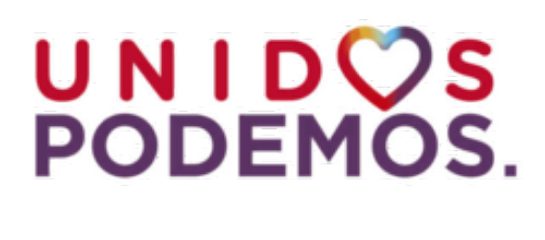
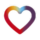
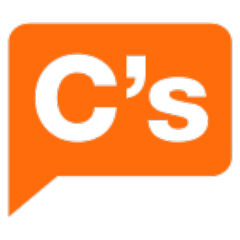
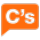
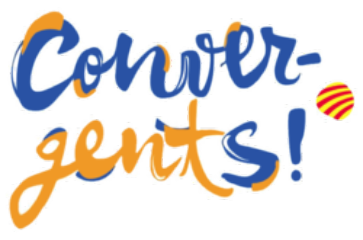
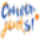
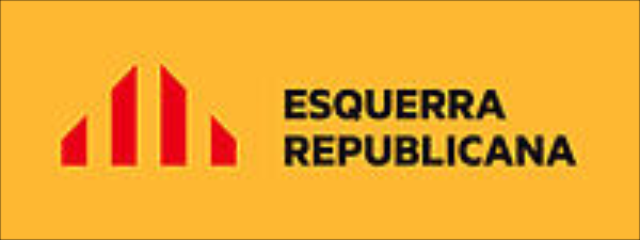
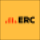
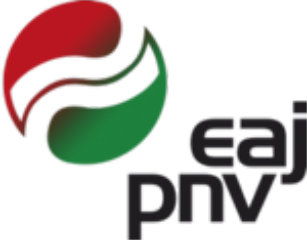
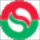
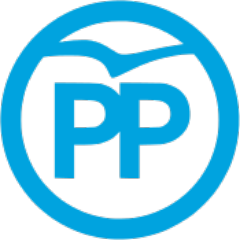
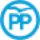
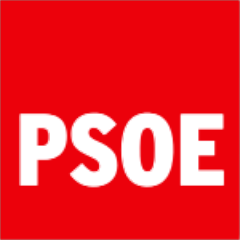
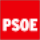

In [6]:
spanish_parties.show_parties()

In the all polls the coalition 'Unidos Podemos' was not together, we can add the parties of the coalition so they are recognized in all polls

In [7]:
spanish_parties_old = from_wiki_table(tables[1])

100%|██████████| 8/8 [00:10<00:00,  1.27s/it]



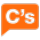
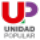
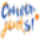
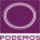
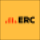
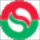
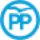
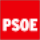

In [8]:
spanish_parties_old.show_parties(small=True)


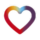
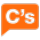
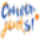
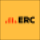
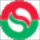
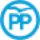
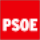

In [9]:
spanish_parties.show_parties(small=True)

Name: Podemos+allies
Full name: Podemos
Short name: POD


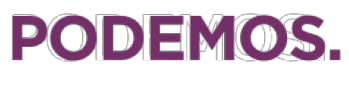

In [10]:
spanish_parties_old['POD'].show()

In [11]:
spanish_parties_old.parties

{"C'S": <mapache.core.Party at 0x7f6323fa90f0>,
 'CDC': <mapache.core.Party at 0x7f6323ef6550>,
 'ERC': <mapache.core.Party at 0x7f6323d86d68>,
 'IU-': <mapache.core.Party at 0x7f6323f60208>,
 'PNV': <mapache.core.Party at 0x7f63240680f0>,
 'POD': <mapache.core.Party at 0x7f63229f6e80>,
 'PP': <mapache.core.Party at 0x7f63645ec5f8>,
 'PSOE': <mapache.core.Party at 0x7f6323c37470>}

In [12]:
coalition_party_names = ['POD', 'IU-']

In [13]:
for p in coalition_party_names:
    spanish_parties['UP'].add_to_coalition(spanish_parties_old[p])

In [14]:
spanish_parties_old.parties['POD']

Name: Unidos Podemos
Full name: Unidos Podemos
Short name: UP
In this coalition:  ['Podemos+allies', 'IU-UPeC']


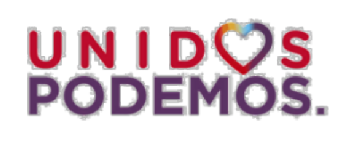

In [15]:
spanish_parties['UP'].show()

## Parsing the polls

## We parse the Wikipedia page to extract each poll and create a _PollsList_ of _Polls_

In [16]:
from dateutil.parser import parse

In [17]:
def poll_from_table(table):
    
    polls = mapache.PollsList("Encuestas")
    
    #Each cell except the first two and the last three corresponds to a party
    row = table.findAll("tr")[0]
    cells = row.findAll("th")  
    party_names = []
    
    for c in cells[2:-3]:
        name = c.find("a").attrs["title"]
        party_names.append(name)

    rows = table.findAll("tr")[2:]
    for row in tqdm(rows):
        
        cells = row.findAll("td")
        if len(cells) <= 3:
            continue
            
        pollster = cells[0].text
        err = cells[-3].text
        if err:
            err = float(err[1:].split(' ')[0])

        date = cells[1].text
        date = parse(date)            


        votes = {}
        for i, p in enumerate(cells[2: -3]):
            v = p.text
            if v:
                try:
                    v = float(v)
                except:
                    # Multiple parties in the cell, fix?
                    continue
                votes[party_names[i]] = v

        poll = mapache.Poll(votes, date, pollster, err)
                
        polls.add(poll)
        
    return polls


In [18]:
polls = poll_from_table(tables[0])

print('{0} polls loaded'.format(len(polls.polls)))

100%|██████████| 33/33 [00:00<00:00, 5402.50it/s]

33 polls loaded


In [19]:
polls.polls[2].print()

Pollster: NC Report
Date: 2016-05-27 00:00:00
Error: 2.2%  
--------------------
CDC: 1.6
PNV: 1.1
ERC: 2.2
Unidos Podemos: 24.7
PP: 30.5
C's: 14.2
PSOE: 21.3


We add the old polls as well (from a different table):

In [20]:
old_polls = poll_from_table(tables[1])

polls.add(old_polls)

print('{0} polls loaded'.format(len(old_polls.polls)))

100%|██████████| 78/78 [00:00<00:00, 5555.75it/s]

76 polls loaded


## Matching polls to parties

As it is likely that the all polls will not have the same name for a party, *mapache* can match a name to the closest party

In [21]:
name = 'ciutadans'
matched = spanish_parties.match(name)

print('\'{0}\' matched to \'{0}\', which included the names: {2}'.format(name, matched.name,
                                                                        matched.get_all_names()))



'ciutadans' matched to 'ciutadans', which included the names: ['Ciudadanos', "C's", "C'S"]


Using name matching it is possible to get all poll results of a party

In [22]:
spanish_parties.match('unidad popular')


In [23]:
old_polls.polls[1].print()

Pollster: Celeste-Tel[CV]
Date: 2016-05-06 00:00:00
Error: 3.1%  
--------------------
IU-UPeC: 5.2
PSOE: 21.7
Podemos+allies: 19.7
C's: 15.2
PP: 28.8


After matching the polls it is possible to plot them. The color corresponding to each party it automatically generated from the logo

*TODO*: Solve clashes between parties with similar colours

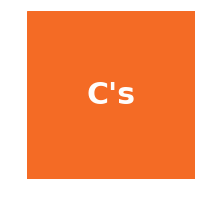

In [24]:
ciudadanos.show_color()

Simple plots can be easily created with the usual matplotlib functions. Note that the match function does not require an specific name for the party

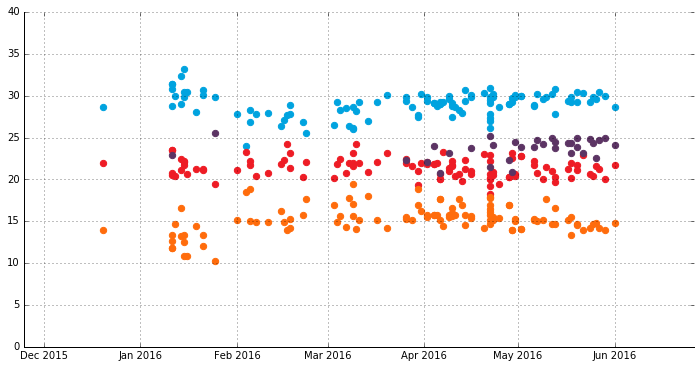

In [25]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=False)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


If __join_coallitions=False__, the votes of the parties being part of a coallition are not sum together, to get them we can set it to true.

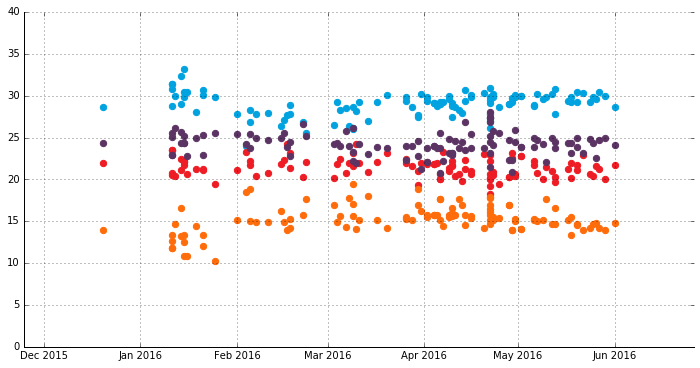

In [26]:
plt.rcParams['figure.figsize'] = (12, 6)
fig, ax = plt.subplots()

parties = ['pp', 'psoe', 'up', 'cs']

for k in parties:
    party_polls = polls.get_party(spanish_parties.match(k), join_coalitions=True)    
    dates = [x[0] for x in party_polls]
    votes = [x[1] for x in party_polls]           
    
    plt.scatter(dates, votes, color=spanish_parties.match(k).color, s=40)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.grid()
plt.ylim((0,40));


# Mapache visualization tools

We will only visualize the four main parties, to extract them from the PartyList

__TODO__: *Automatically select the top N parties* 

In [27]:
main_parties = spanish_parties.extract(['PP', 'PSOE', 'Unidos Podemos', 'Cs'])


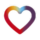
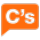
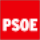
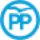

In [28]:
main_parties.show_parties(small=True)

## Visualizing a poll

In [29]:
poll=polls.polls[2]

In [30]:
elections = polls.polls[-1]

#### Bar plot
A simple plot of the parties selected (sorted by votes)

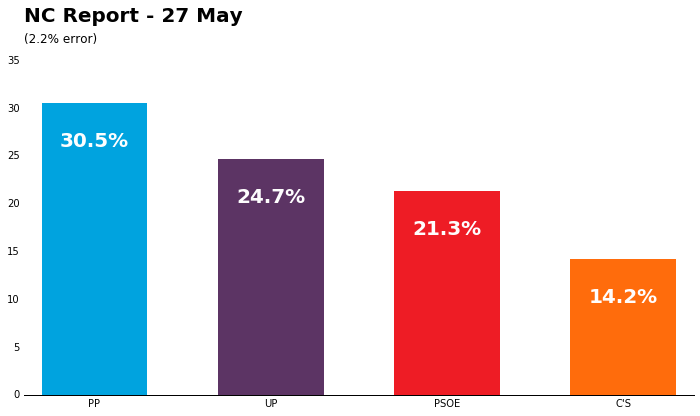

In [31]:
mapache.vis.SingleBars(poll, main_parties);

An indication of the result in a different Poll (eg. the elections) can be easily added:

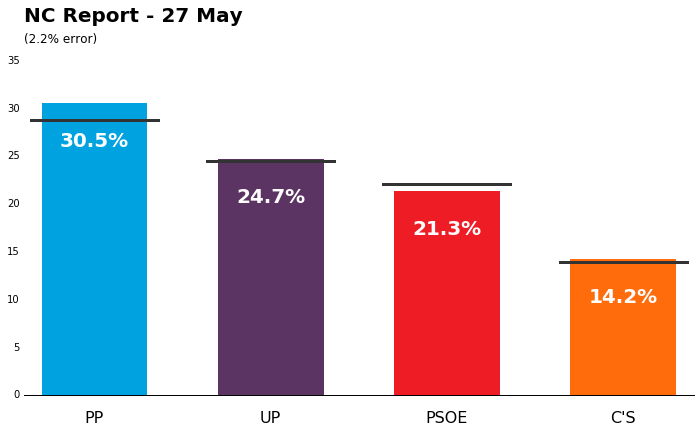

In [32]:
mapache.vis.SingleBars(poll, main_parties, elections=elections);

#Add label to the line!

#### Horizontal bar plot
#### The old good pie?

## Visualizing several polls

#### Time series 
A more complex visualization including many polls. 
In this case we will load the polls previous to the last election.

In [33]:
wiki_2015 = "https://en.wikipedia.org/wiki/Opinion_polling_for_the_Spanish_general_election,_2015"
page_2015 = urllib.request.urlopen(wiki_2015)
soup_2015 = BeautifulSoup(page_2015, "html.parser")
tables_2015 = soup_2015.findAll("table", class_="wikitable")

parties_2015 = from_wiki_table(tables_2015[0])
polls_2015 = poll_from_table(tables_2015[0])
polls_2015._name = 'Opinion Polls'


100%|██████████| 420/420 [00:00<00:00, 2441.84it/s]



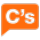
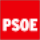
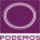
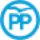

In [34]:
parties_2015 = parties_2015.extract(['PP', 'PSOE', 'Podemos', 'Cs'])
parties_2015.show_parties(small=True)

In [47]:
elections = polls_2015.polls[0]

#TODO Modify TimeSeries to accept Poll instead of PollList!

elections20D = mapache.PollsList()
elections20D.add(elections)
elections20D._name = 'Elections 20D'

del polls_2015.polls[0]

In [48]:
import imp
imp.reload(mapache.vis)

<module 'mapache.vis' from '../mapache/vis.py'>

In [49]:
ts = mapache.vis.TimeSeries(parties_2015)

In [50]:
# A column with all the polls (add gps to arg)
ts.add_column(polls_2015)

# A column with the election results
ts.add_column(elections20D)

last
0 15.2
0 20.5
0 21.7
0 26.8


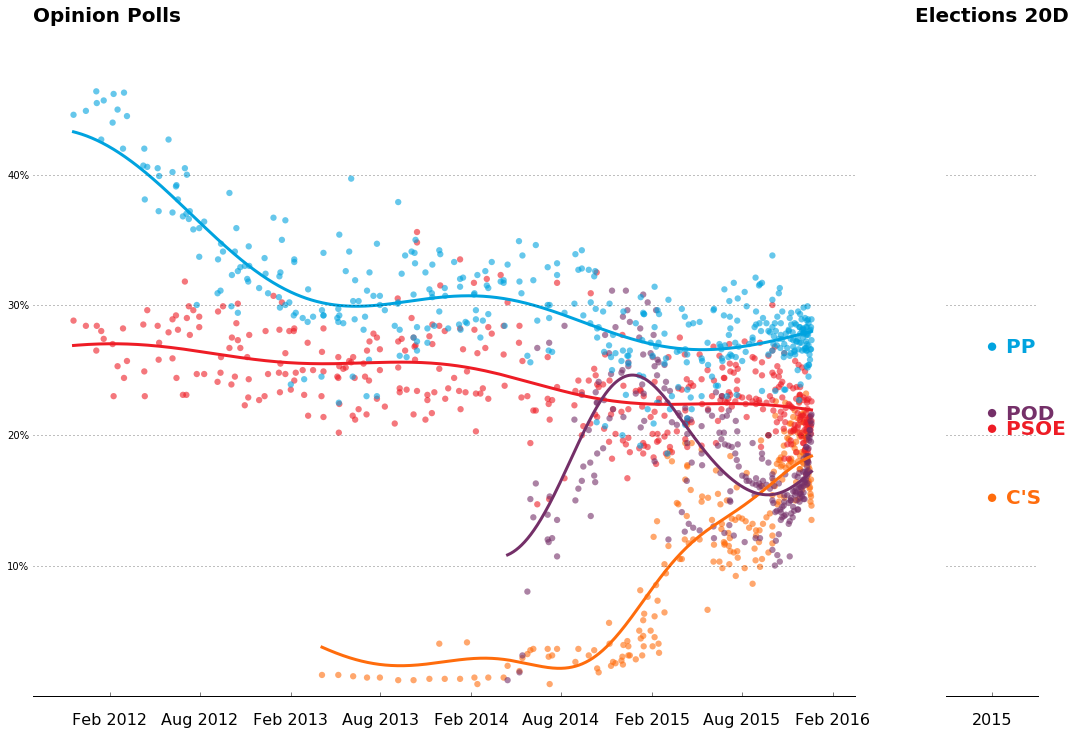

In [51]:
ts.show()